# Grid Search for a Decision Tree

In [1]:
library(caret)
library(MLmetrics)
library(rpart)
library(tidyverse)
library(magrittr)
source("helpers.r")


df <- get_training_df_clean()


set.seed(25)
number_of_folds <- 10
folds <- createFolds(df$target, k = number_of_folds)


f <- function(maxdepth, minsplit, minbucket, cp) {
  
  auc <- vector(mode = "numeric", length = number_of_folds)
  
  for(fold_index in c(1:number_of_folds)){
    training <- df[-folds[[fold_index]],]
    test <- df[folds[[fold_index]],]
    
    fit <- rpart(target ~., data=training, method = "class",
                 control = rpart.control(maxdepth = maxdepth, minbucket = minbucket, minsplit = minsplit), cp = cp)
    # using ratio of poisitive labels as probability
    y_probabilities <- predict(fit, test)[,2]
  

    y_true <- ifelse(test$target == "no_disease", 0, 1)
    
    auc[fold_index] <- AUC(y_true = y_true, y_pred = y_probabilities)
    
    
  }
  
  return(mean(auc))
  
}


result <- tibble(auc = vector(mode = "numeric"),
                 minsplit = vector(mode = "numeric"),
                 minbucket = vector(mode = "numeric"),
                 maxdepth = vector(mode = "numeric"),
                 cp = vector(mode = "numeric"))


# the minimum number of observations that must exist in a node in order for a
# split to be attempted.
minsplits <- c(10, 20, 30)

# the minimum number of observations in any terminal <leaf> node. If only
# one of minbucket or minsplit is specified, the code either sets minsplit to
# minbucket*3 or minbucket to minsplit/3, as appropriate.
minbuckets <-  c(3, 7, 10)
   
# Set the maximum depth of any node of the final tree, with the root node counted
# as depth 0. Values greater than 30 rpart will give nonsense results on 32-bit
# machines  r
maxdepths <-  c(5, 10, 20)

cps <- c(0.1, 0.01, 0.001)

for(maxdepth in maxdepths) {
  for(cp in cps){
    for(minsplit in minsplits) {
      for(minbucket in minbuckets){
    
        auc <- f(maxdepth, minsplit, minbucket,  cp)
    result %<>% 
      add_row(auc = auc, 
              maxdepth = maxdepth,
              minsplit = minsplit,
              minbucket = minbucket,
              cp = cp)

      }
    }
  }
}

result  <- result %>%
  arrange(desc(auc))

head(result, n = 5)

Warning message:
"package 'caret' was built under R version 3.6.1"Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'MLmetrics' was built under R version 3.6.1"
Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:base':

    Recall

Warning message:
"package 'tidyverse' was built under R version 3.6.1"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  2.1.1       v purrr   0.3.2  
v tidyr   0.8.3       v dplyr   0.8.0.1
v readr   1.3.1       v stringr 1.4.0  
v tibble  2.1.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x purrr::lift()   

auc,minsplit,minbucket,maxdepth,cp
0.8285864,10,10,5,0.100
0.8285864,20,10,5,0.100
0.8285864,10,10,5,0.010
0.8285864,20,10,5,0.010
0.8285864,10,10,5,0.001


Cannot reach the performance of the logistic regression models. Let's inspect the tree.

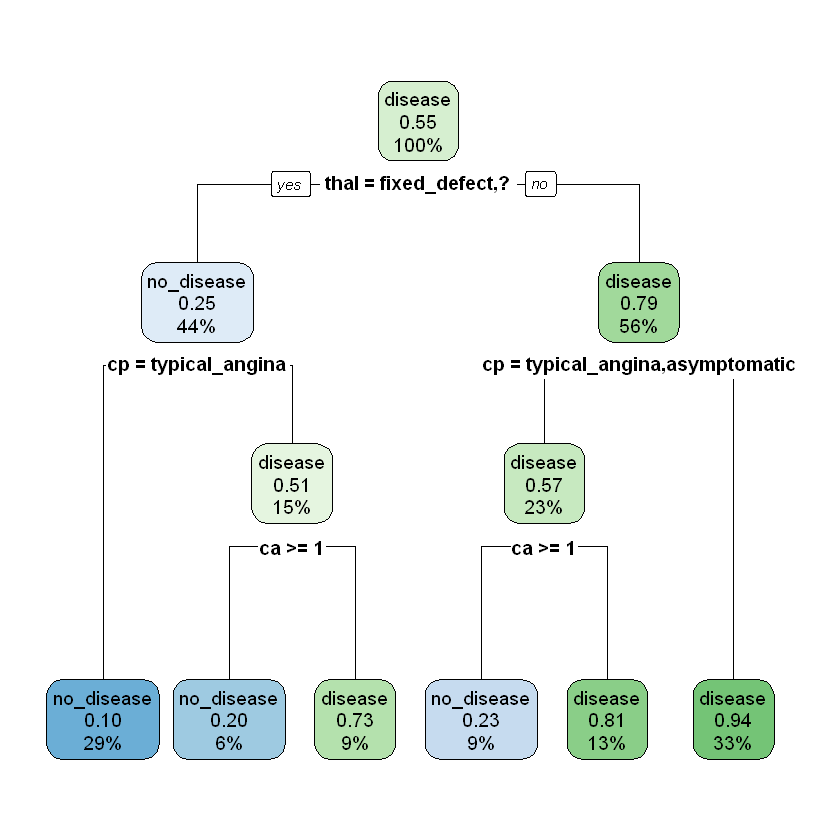

In [2]:
library(rpart.plot)
fit <- rpart(target ~., data=df, method = "class",
                 control = rpart.control(maxdepth = 5, minbucket = 10, minsplit = 10), cp = 0.1)
rpart.plot(fit)